In [8]:
# import
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.cluster import KMeans
from L63_noisy import intL63_noisy, intL63_noisy_fix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa import stattools 
from scipy.stats import gaussian_kde
import joblib
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
# from sklearn.metrics import silhouette_score
from scipy.integrate import odeint
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# from FKNN import FuzzyKNN, calculate_distances
from sklearn.metrics import silhouette_score
from scipy import io
from scipy.linalg import det
from selecandies import physi_constrain, selc_candifunc, indicate, find_index, find_index_flatten 
from collections import defaultdict
import os
from collections import Counter
from scipy.io import loadmat


# fix the random seed
np.random.seed(2022)

In [2]:
# set experiment parameters
dt = 0.03  # model integration time step, dtda should be divisible to dt
N = int(1e6)  # integration time steps
res = 1 # save data interval 
eps = 0.75 # noise level
save_res = 10

In [3]:
0.03*2048

61.44

100%|███████████████████████████████| 999999/999999 [00:05<00:00, 189130.14it/s]


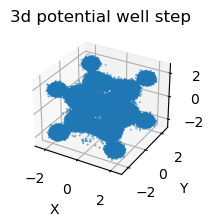

In [4]:
# modified 3d potential well (change one coefficient to time-dependent variable)
def U(v, t):
    Ax = 1.05
    Ay = 1.1
    Az = 1.15
    x, y, z = v
    return (x - Ax)**2 * (x + Ax)**2 + (y - Ay)**2 * (y + Ay)**2 + (z - Az)**2 * (z + Az)**2

def force(v, t):
    T = 61.44 #  # period time
    q = 0.7
    if (t // T) % 2 == 0:
        Ax = 1.05
        Ay = 1.1
        Az = 1.15
    else:
        Ax = 1.05 + q
        Ay = 1.1 + q
        Az = 1.15 + q
    x, y, z = v
    dxdt = -(2*(-Ax+x)**2*(Ax+x)+2*(-Ax+x)*(Ax+x)**2)
    dydt = -(2*(-Ay+y)**2*(Ay+y)+2*(-Ay+y)*(Ay+y)**2)
    dzdt = -(2*(-Az+z)**2*(Az+z)+2*(-Az+z)*(Az+z)**2)
    return np.array([dxdt,dydt,dzdt])

def potential_data(timesteps, dt, res, eps):
    x_f = np.zeros((3, timesteps))
    der = np.zeros((3, timesteps))
    
    for i in tqdm(range(1, timesteps)):
        dx = force(x_f[:, i-1], dt*(i-1)) * dt
        x_f[:, i] = x_f[:, i-1] + dx  + eps * np.sqrt(dt) * np.random.randn(3)
        der[:, i-1] = x_f[:, i] - x_f[:, i-1]
        
    dx = force(x_f[:, -1], dt*(timesteps-1)) * dt
    sol = x_f[:, -1] + dx  + eps * np.sqrt(dt) * np.random.randn(3)
    der[:, -1] = sol - x_f[:, -1]

    L2 = timesteps // res
    Dt = dt * res
    x = np.zeros((3, L2))
    
    for i in range(L2):
        x[:, i] = x_f[:, res*i]

    return x, Dt, der


x, dt, der = potential_data(N, dt, res, eps)

np.save('../../data/naturerun_PWell_step_bigT.npy', x)
np.save('../../data/derivative_PWell_step_bigT.npy', der)
# mat_file = 'naturerun_pwell_step.mat'
# io.savemat(mat_file, {'data': x})

# Set up the loop and plot
fig =  plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[0,:], x[1,:], x[2,:], s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.savefig('../../fig/3dPotentialWell_step_bigT.png')
plt.show()

In [3]:
# load data
truth = np.load('../../data/naturerun_PWell_step_bigT.npy')
truth.shape

(3, 1000000)

In [6]:
# save data to hdf5 file
save_res = 10
with h5py.File("../../data/potential_well_step_bigT.hdf5", "w") as hfile:
    # Store data in the file
    hfile["x"] = truth[:,::save_res].T
    hfile["dt"] = dt*save_res


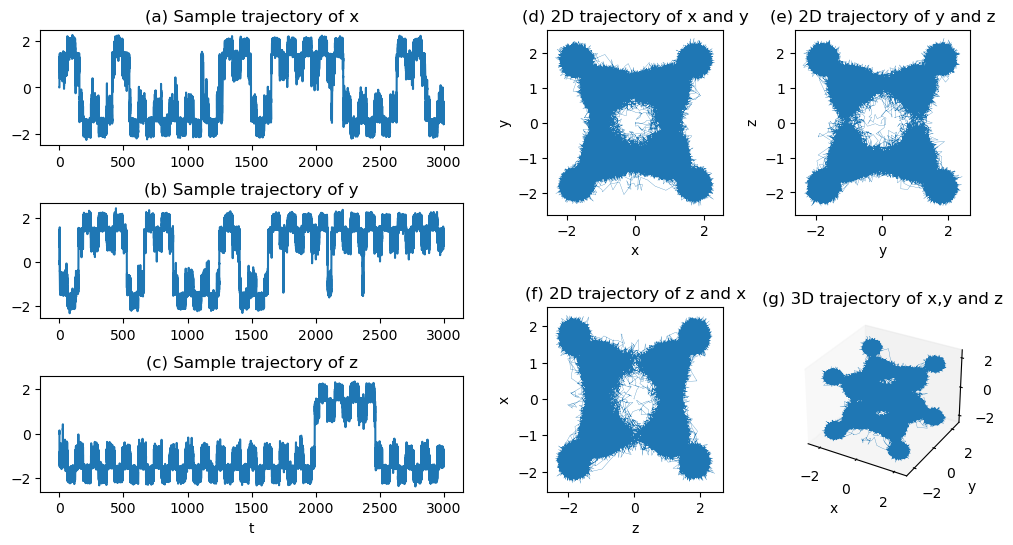

In [7]:
# Plot - step
x1, y1, z1 = truth

sel0 = 0; sel1 = 100000 # plot time range
interv = 1 # plot interval
xaxis = np.arange(sel0*dt, sel1*dt, interv*dt)

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)     # Adjust the overall spacing of the figure
gs0 = GridSpec(1, 2, figure=fig)

gs00 = gs0[0].subgridspec(3, 6)
ax1 = fig.add_subplot(gs00[0, :])
ax2 = fig.add_subplot(gs00[1, :])
ax3 = fig.add_subplot(gs00[2, :])

ax1.plot(xaxis, x1[sel0:sel1:interv])
# ax1.set_xlim(50, 100)
ax1.set_title('(a) Sample trajectory of x')

ax2.plot(xaxis, y1[sel0:sel1:interv])
# ax2.set_xlim(50, 100)
ax2.set_title('(b) Sample trajectory of y')

ax3.plot(xaxis, z1[sel0:sel1:interv])
# ax3.set_xlim(50, 100)
ax3.set_title('(c) Sample trajectory of z')
ax3.set_xlabel('t')

# create a new GridSpec for the second column
gs01 = gs0[1].subgridspec(2, 7)

ax4 = fig.add_subplot(gs01[0, :3])
ax5 = fig.add_subplot(gs01[0, 4:])
ax6 = fig.add_subplot(gs01[1, :3])
ax7 = fig.add_subplot(gs01[1, 4:], projection='3d')

ax4.plot(x1, y1, lw=0.2)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title('(d) 2D trajectory of x and y')

ax5.plot(y1, z1, lw=0.2)
ax5.set_xlabel('y')
ax5.set_ylabel('z')
ax5.set_title('(e) 2D trajectory of y and z')

ax6.plot(z1, x1, lw=0.2)
ax6.set_xlabel('z')
ax6.set_ylabel('x')
ax6.set_title('(f) 2D trajectory of z and x')

ax7.plot(x1, y1, z1, lw=0.2)
ax7.set_xlabel("x")
ax7.set_ylabel("y")
ax7.set_zlabel("z")
ax7.set_title('(g) 3D trajectory of x,y and z')
ax7.grid(False)

plt.savefig('../../fig/Truth_traj_PWell_step_bigT.png', dpi=150)
plt.show()

# 1. Classification

## 1.1 autocorrelation

x Decorrelation Time: 52.47 time units
y Decorrelation Time: 91.50 time units
z Decorrelation Time: 247.23 time units


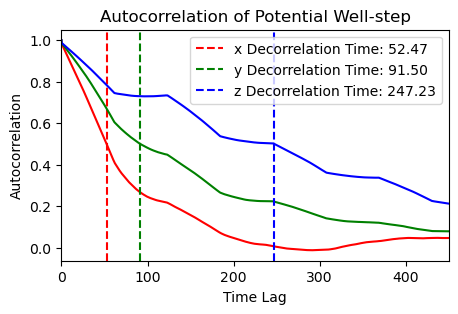

In [8]:
# compute autocorrelation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools 

nlags = 15000

autocorr_x = stattools.acf(truth[0,:],nlags=nlags)  # Autocorrelation of x component
autocorr_y = stattools.acf(truth[1,:],nlags=nlags)  # Autocorrelation of y component
autocorr_z = stattools.acf(truth[2,:],nlags=nlags)  # Autocorrelation of z component

# Find decorrelation time (time lag at which autocorrelation drops to a certain threshold)
threshold = 0.5
decorrelation_time_index = np.argmax(autocorr_x < threshold)
decorrelation_time_x = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_y < threshold)
decorrelation_time_y = decorrelation_time_index * dt
decorrelation_time_index = np.argmax(autocorr_z < threshold)
decorrelation_time_z = decorrelation_time_index * dt

tmax = dt*autocorr_x.shape[0]
t = np.arange(0.0, tmax, dt)
# Plot autocorrelation function and decorrelation time
plt.figure(figsize=(5,3))
plt.plot(t, autocorr_x, color='r')
plt.axvline(x=decorrelation_time_x, color='r', linestyle='--', label=f'x Decorrelation Time: {decorrelation_time_x:.2f}')
plt.plot(t, autocorr_y, color='g')
plt.axvline(x=decorrelation_time_y, color='g', linestyle='--', label=f'y Decorrelation Time: {decorrelation_time_y:.2f}')
plt.plot(t, autocorr_z, color='b')
plt.axvline(x=decorrelation_time_z, color='b', linestyle='--', label=f'z Decorrelation Time: {decorrelation_time_z:.2f}')
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Potential Well-step')
plt.legend()
plt.xlim(0, tmax)
# plt.show()
plt.savefig('../../fig/autocorr_PWell_step_bigT.png', dpi=150)

print(f"x Decorrelation Time: {decorrelation_time_x:.2f} time units")
print(f"y Decorrelation Time: {decorrelation_time_y:.2f} time units")
print(f"z Decorrelation Time: {decorrelation_time_z:.2f} time units")

## 1.2 Clustering

In [4]:
# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# K-means clustering
# Create feature matrix (x, y, z) for clustering
data_matrix = X
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']


### 1.2.0 True dynamics regimes

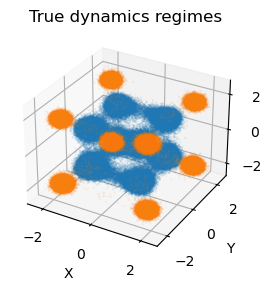

In [10]:
# true regimes
T = 61.44 #  # period time
lbs = np.ones(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 0
    
# check overlap for ncenters=16
fig1, axes1 = plt.subplots(1, 1, figsize=(3,3), subplot_kw=dict(projection='3d'))
ncenters = 2
ax = axes1

dic = {'label':lbs}
np.save('../../data/True_Regimes_Pwell_step_bigT.npy'.format(ncenters), dic)

# Plot assigned clusters, for each data point in training set
for j in range(ncenters):
    ax.scatter(x_data[lbs == j], y_data[lbs == j], z_data[lbs == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('True dynamics regimes'.format(ncenters))
plt.savefig('../../fig/true_regime_pwell_step_bigT.png', dpi=150)
plt.show()

### 1.2.1 K-means

/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ree/miniconda3/envs/py/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

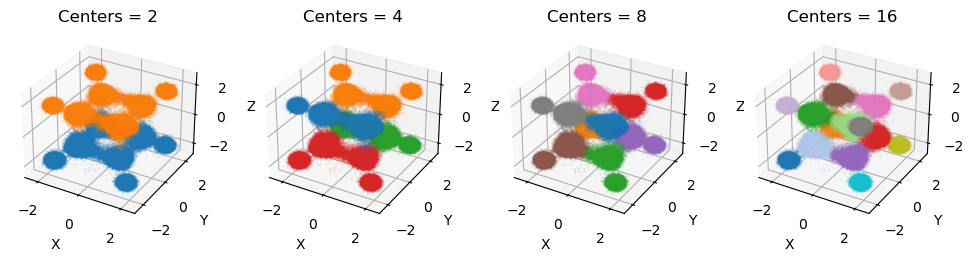

In [11]:
# Kmeans
%matplotlib inline
# Define a custom function to evaluate the predictions with multiple metrics
def evaluate_predictions(truth_label, predicted_label):
    accuracy = accuracy_score(truth_label, predicted_label)
    precision = precision_score(truth_label, predicted_label, average='macro')
    recall = recall_score(truth_label, predicted_label, average='macro')
    return accuracy, precision, recall,

ncenterss = [2,4,8,16]

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection='3d'))

for ncenters, ax in zip(ncenterss, axes1):
    kmeans = KMeans(n_clusters=ncenters)#, n_init='auto')
    kmeans.fit(data_matrix)
    labels = kmeans.labels_

    # save data
    dic = {'label':labels, 'centers':kmeans.cluster_centers_}
    np.save('../../data/Kmeans_{0:d}center_Pwell_step_bigT.npy'.format(ncenters), dic)
    joblib.dump(kmeans, "../../data/kmeans_model_{0:d}center_PWell_step_bigT.joblib".format(ncenters))

#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    for j in range(ncenters):
        ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    ax.set_title('Centers = {0}'.format(ncenters))

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Kmeans_PWell_step_bigT.png',dpi=150)
plt.show()

In [ ]:
# check overlap for ncenters=16
%matplotlib notebook
fig1, axes1 = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
ncenters = 16
ax = axes1

# Plot assigned clusters, for each data point in training set
for j in range(ncenters):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('Centers = {0}'.format(ncenters))

In [ ]:
# check overlap for ncenters=16
fig1, axes1 = plt.subplots(2, 3, figsize=(10, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.3)     # Adjust the overall spacing of the figure

for j in range(ncenters-8):
    axes1[0][0].scatter(x_data[labels == j], y_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[0][0].set_xlabel('X')
    axes1[0][0].set_ylabel('Y')
    
    axes1[0][1].scatter(y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[0][1].set_xlabel('Y')
    axes1[0][1].set_ylabel('Z')
    
    axes1[0][2].scatter(z_data[labels == j], x_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[0][2].set_xlabel('Z')
    axes1[0][2].set_ylabel('X')

for j in range(ncenters-8,ncenters):
    axes1[1][0].scatter(x_data[labels == j], y_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[1][0].set_xlabel('X')
    axes1[1][0].set_ylabel('Y')
    
    axes1[1][1].scatter(y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[1][1].set_xlabel('Y')
    axes1[1][1].set_ylabel('Z')
    
    axes1[1][2].scatter(z_data[labels == j], x_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    axes1[1][2].set_xlabel('Z')
    axes1[1][2].set_ylabel('X')

fig1.suptitle('Centers=16')

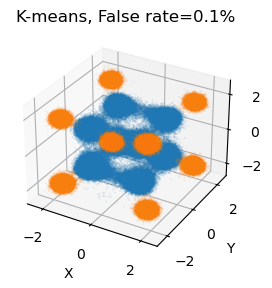

In [49]:
# combining 16 regimes to 2 regimes
%matplotlib inline
# load label data
labels = np.load('../../data/Kmeans_16center_Pwell_step_bigT.npy',allow_pickle=True).item()['label']
centers = np.load('../../data/Kmeans_16center_Pwell_step_bigT.npy',allow_pickle=True).item()['centers']
rgm=[]
rg0 = [nc for nc in range(16) if abs(centers[nc][0]) > 1.5]
rgm.append(rg0)
rg1 = [nc for nc in range(16) if abs(centers[nc][0]) <= 1.5]
rgm.append(rg1)

# check overlap for ncenters=16
fig1, axes1 = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(projection='3d'))
ncenters = 16
ax = axes1
newlabels = np.zeros(labels.shape)

# Plot assigned clusters, for each data point in training set
for ilabel in rgm[1]:
    newlabels[labels==ilabel] = 1

dic = {'label':newlabels}
np.save('../../data/Kmeans_2rgm_Pwell_step_bigT.npy', dic)

# Plot assigned clusters, for each data point in training set
for j in range(2):
    ax.scatter(x_data[newlabels == -j+1], y_data[newlabels == -j+1], z_data[newlabels == -j+1],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('K-means, False rate={0:.1f}%'.format(100-100*np.sum(abs(lbs-newlabels)/lbs.shape[0])))
plt.savefig('../../fig/kmeans_2rgm_potential_well_step_bigT.png', dpi=150)


### 1.2.2 Fuzzy Cmeans

In [ ]:
# Fuzzy C-Means
%matplotlib inline

def bi2fuzzy(nc, label):
    N = label.shape[0]
    membership = np.zeros((nc, N))
    for ic in range(nc):
        membership[ic, label==ic] = 1
        
    return membership
    
# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]
ncenterss = [2,4,8,16]

# Set up the loop and plot
fig1, axes1 = plt.subplots(1, 4, figsize=(12, 3), subplot_kw=dict(projection='3d'))
fpcs = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

for ncenters, ax in zip(ncenterss, axes1):
    # initialize with kmeans
    dic = np.load('../../data/Kmeans_{0:d}center_Pwell_step.npy'.format(ncenters), allow_pickle=True)
    lb = dic.item()['label']
    init_mem = bi2fuzzy(ncenters, lb)
    
    # # Perform Fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data_matrix.T, ncenters, 2, error=0.005, maxiter=300, init=init_mem)

    # Store fpc values for later
    fpcs.append(fpc)
    
#     print('number of iterations:',p)
    
    # Plot assigned clusters, for each data point in training set
    cluster_membership_bi = np.argmax(u, axis=0)
    cluster_membership = u

    for j in range(ncenters):
        ax.scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.scatter(pt[0], pt[1], pt[2], marker='s', s=20, color='black')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))

    # save data
    dic = {'label':cluster_membership_bi, 'centers':cntr, 'membership':cluster_membership,'u0':u0,'d':d,'jm':jm,'p':p,'fpc':fpc}
    np.save('../../data/FuzKmeans_{0:d}center_PWell_step.npy'.format(ncenters), dic)

plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/FCmeans_PWell_step.png', dpi=150)
plt.show()


In [ ]:
# check overlap for ncenters=16
%matplotlib notebook

fig1, axes1 = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
fpcs = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

ncenters = 16
ax = axes1
for j in range(ncenters):
    ax.scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Mark the center of each fuzzy cluster
for pt in cntr:
    ax.scatter(pt[0], pt[1], pt[2], marker='s', s=20, color='black')

ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))


In [ ]:
# check overlap for ncenters=16
%matplotlib inline

fig1, axes1 = plt.subplots(2, 3, figsize=(10, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.3)     # Adjust the overall spacing of the figure
alpha = 0.3
for j in range(ncenters-8):
    axes1[0][0].scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[0][0].set_xlabel('X')
    axes1[0][0].set_ylabel('Y')
    
    axes1[0][1].scatter(y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[0][1].set_xlabel('Y')
    axes1[0][1].set_ylabel('Z')
    
    axes1[0][2].scatter(z_data[cluster_membership_bi == j], x_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[0][2].set_xlabel('Z')
    axes1[0][2].set_ylabel('X')

for j in range(ncenters-8,ncenters):
    axes1[1][0].scatter(x_data[cluster_membership_bi == j], y_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[1][0].set_xlabel('X')
    axes1[1][0].set_ylabel('Y')
    
    axes1[1][1].scatter(y_data[cluster_membership_bi == j], z_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[1][1].set_xlabel('Y')
    axes1[1][1].set_ylabel('Z')
    
    axes1[1][2].scatter(z_data[cluster_membership_bi == j], x_data[cluster_membership_bi == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=alpha)
    axes1[1][2].set_xlabel('Z')
    axes1[1][2].set_ylabel('X')

fig1.suptitle('Centers=16')

In [ ]:
# combining 16 regimes to 2 regimes
%matplotlib inline
# load label data
labels = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']
centers = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['centers']
rgm=[]
rg0 = [nc for nc in range(16) if abs(centers[nc][0]) > 1.5]
rgm.append(rg0)
rg1 = [nc for nc in range(16) if abs(centers[nc][0]) <= 1.5]
rgm.append(rg1)

# check overlap for ncenters=16
fig1, axes1 = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(projection='3d'))
ncenters = 16
ax = axes1
newlabels = np.zeros(labels.shape)

# Plot assigned clusters, for each data point in training set
for ilabel in rgm[1]:
    newlabels[labels==ilabel] = 1

dic = {'label':newlabels}
# np.save('../../data/FuzKmeans_{0:d}center2rgm_Pwell_step.npy'.format(ncenters), dic)

# Plot assigned clusters, for each data point in training set
for j in range(2):
    ax.scatter(x_data[newlabels == -j+1], y_data[newlabels == -j+1], z_data[newlabels == -j+1],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

ax.set_title('FCM, False rate={0:.1f}%'.format(100*np.sum(abs(lbs-newlabels)/lbs.shape[0])))
plt.savefig('../../fig/fcm_16cntr2rgm_potential_well_step.png', dpi=150)


### 1.2.3 Maximum Entropy Clusetering (MEC)

In [ ]:
# load mec clustering results from .mat file
mat = io.loadmat('../../data/mec_pwell_step.mat')  # Replace 'your_data.mat' with your file name

# Access the variables in the loaded .mat file
label = mat['mec_results']['label'][0, 0]
centers = mat['mec_results']['para_miu'][0, 0]
membership = mat['mec_results']['responsivity'][0, 0]


### 1.2.4 Ludo's Method

number of clusters: [ 3  4  6  7 16 17 17 17]
time scales: [356.1236972   96.03874239  28.24166121  17.55239104   0.47260659
   0.42951191   0.37782073   0.36960425]


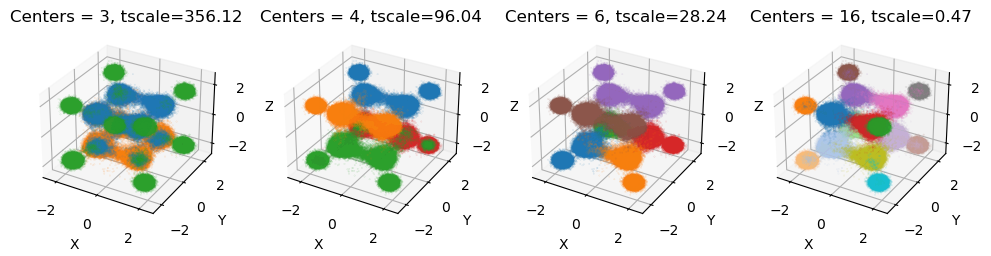

In [33]:
# Ludo's method
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_bigT32.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]

ncenterss = np.max(np.array(labels_)+1, axis=1)
ncenterss = ncenterss[:8]

print('number of clusters:', ncenterss)
print('time scales:', tscales)

# Set up the loop and plot
nrow, ncol = (1,4)
fig1, axes1 = plt.subplots(nrow, ncol, figsize=(12, 4), subplot_kw=dict(projection='3d'))
ilabel = 0
jax = 0
for ilabel in [0,1,2,4]:
    labels = labels_[ilabel]
    ncenters = ncenterss[ilabel]
    
#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    for j in range(ncenters):
        axes1[jax].scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        axes1[jax].set_xlabel('X')
        axes1[jax].set_ylabel('Y')
        axes1[jax].set_zlabel('Z')
#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    axes1[jax].set_title('Centers = {0:d}, tscale={1:.2f}'.format(ncenters, tscales[ilabel]))
    jax += 1
    
plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Ludos_PWell_step_bigT32.png',dpi=150)
plt.show()

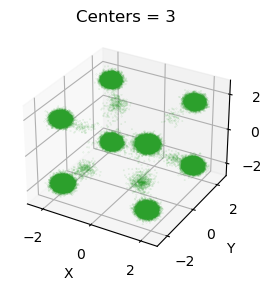

In [17]:
# inspect regimes
# %matplotlib notebook
itscale = 0
labels = labels_[itscale]
ncenters = ncenterss[itscale]
# Plot assigned clusters, for each data point in training set
fig1, ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
for j in range(2,3):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    

ax.set_title('Centers = {0}'.format(ncenters))
plt.show()

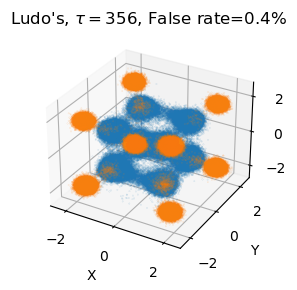

In [45]:
# combining 3 regimes to 2 regimes
%matplotlib inline

# load label data
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

save_res = 10

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_bigT.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]
label = labels_[0]

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster_bigT.mat', 'r') as file:
    X_ = file['X'][()]
    X_ = np.repeat(X_, save_res)-1
    centers = file['Xc'][()]

rgms=[]
rg0 = [2]
rgms.append(rg0)
rg1 = [0,1]
rgms.append(rg1)

fig1, axes1 = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(projection='3d'))
ncenters = 4
ax = axes1
newlabels = np.zeros(label.shape)

# Plot assigned clusters, for each data point in training set
for ilabel in rgms[1]:
    newlabels[label==ilabel] = 1

dic = {'label':newlabels}
np.save('../../data/Ludos_{0:d}center2rgm_Pwell_step_bigT.npy'.format(ncenters), dic)

# Plot assigned clusters, for each data point in training set
for j in range(2):
    ax.scatter(x_data[newlabels == -j+1], y_data[newlabels == -j+1], z_data[newlabels == -j+1],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

tau_value = 356  # Example value for tau
false_rate = 100 - 100 * np.sum(np.abs(lbs - newlabels)) / lbs.shape[0]
title = f"Ludo's, $\\tau={tau_value}$, False rate={false_rate:.1f}%"
ax.set_title(title)
plt.savefig('../../fig/ludos_2rgm_potential_well_step_bigT.png', dpi=150)

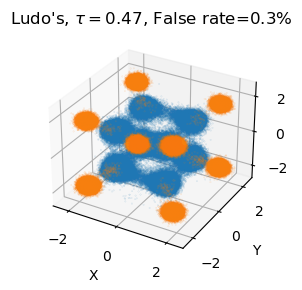

In [48]:
# combining 3 regimes to 2 regimes
%matplotlib inline

# load label data
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

save_res = 10

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_bigT32.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]
label = labels_[4]

# with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster_bigT32.mat', 'r') as file:
#     X_ = file['X'][()]
#     X_ = np.repeat(X_, save_res)-1
#     centers = file['Xc'][()]

rgm=[]
rg0 = [nc for nc in range(16) if abs(np.mean(x_data[label==nc])) > 1.5]
rgm.append(rg0)
rg1 = [nc for nc in range(16) if abs(np.mean(x_data[label==nc])) <= 1.5]
rgm.append(rg1)


fig1, axes1 = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(projection='3d'))
ncenters = 4
ax = axes1
newlabels = np.zeros(label.shape)

# Plot assigned clusters, for each data point in training set
for ilabel in rgm[1]:
    newlabels[label==ilabel] = 1

dic = {'label':newlabels}
np.save('../../data/Ludos_{0:d}center2rgm_Pwell_step_bigT.npy'.format(ncenters), dic)

# Plot assigned clusters, for each data point in training set
for j in range(2):
    ax.scatter(x_data[newlabels == -j+1], y_data[newlabels == -j+1], z_data[newlabels == -j+1],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

tau_value = 0.47  # Example value for tau
false_rate = 100 - 100 * np.sum(np.abs(lbs - newlabels)) / lbs.shape[0]
title = f"Ludo's, $\\tau={tau_value}$, False rate={false_rate:.1f}%"
ax.set_title(title)
plt.savefig('../../fig/ludos_2rgm_potential_well_step_bigT32.png', dpi=150)

number of clusters: [2 3 3 3 4 3 4 4]
time scales: [356.1236972  203.51057374 152.90040981 108.1855959   96.03874239
  93.16485727  86.90847051  30.79365839]


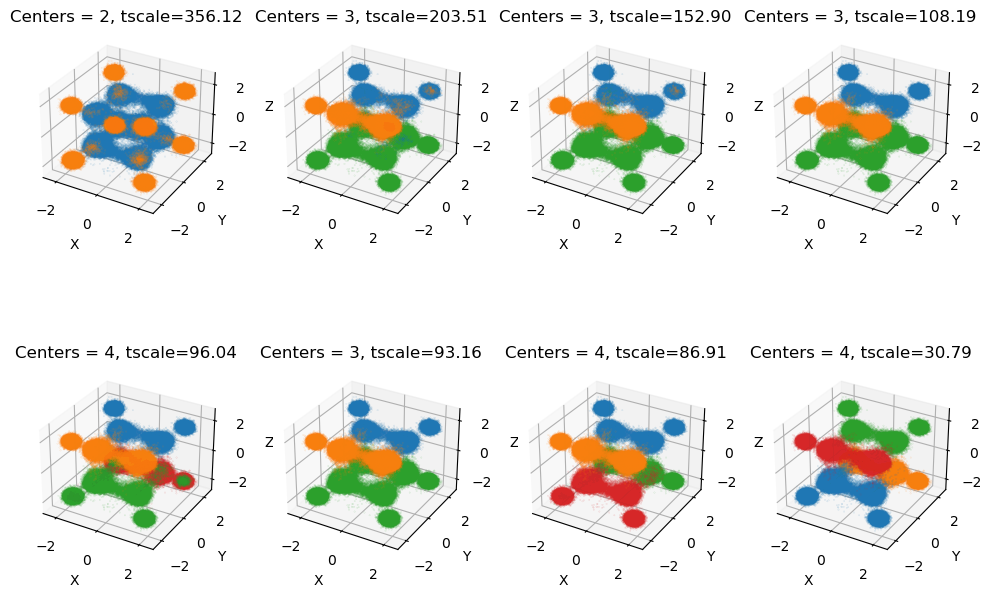

In [6]:
# Ludo's method - q_min = 0.1
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_bigT_q01.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]

ncenterss = np.max(np.array(labels_)+1, axis=1)
ncenterss = ncenterss[:8]

print('number of clusters:', ncenterss)
print('time scales:', tscales)

# Set up the loop and plot
nrow, ncol = (2,4)
fig1, axes1 = plt.subplots(nrow, ncol, figsize=(12, 8), subplot_kw=dict(projection='3d'))
ilabel = 0
for ncenters in ncenterss:
    labels = labels_[ilabel]
    
#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    iax = int(ilabel // ncol)
    jax = ilabel % ncol
    for j in range(ncenters):
        axes1[iax,jax].scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        axes1[iax,jax].set_xlabel('X')
        axes1[iax,jax].set_ylabel('Y')
        axes1[iax,jax].set_zlabel('Z')
#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    axes1[iax,jax].set_title('Centers = {0:d}, tscale={1:.2f}'.format(ncenters, tscales[ilabel]))

    ilabel += 1
    
plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Ludos_PWell_step_bigT_q01.png',dpi=150)
plt.show()

In [13]:
# true regimes
T = 61.44 #  # period time
lbs = np.ones(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 0

<IPython.core.display.Javascript object>


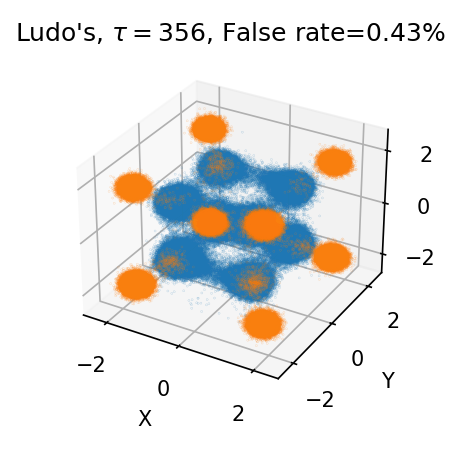

In [16]:
# save label
%matplotlib notebook

# load label data
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

save_res = 10

# with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo.mat', 'r') as file:
#     labels_ = read_matlab_cell_array(file,'X_LN_array')
#     labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
#     tscales = file['tau'][()]
# label = labels_[2]

# with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster.mat', 'r') as file:
#     X_ = file['X'][()]
#     X_ = np.repeat(X_, save_res)-1
#     centers = file['Xc'][()]

# rgms=[]
# rg0 = [nc for nc in range(4) if np.max(abs(z_data[label == nc])) > 2.4]
# rgms.append(rg0)
# rg1 = [nc for nc in range(4) if np.max(abs(z_data[label == nc])) <= 2.4]
# rgms.append(rg1)

# fig1, axes1 = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
# ncenters = 4
# ax = axes1
# newlabels = np.zeros(label.shape)

# # Plot assigned clusters, for each data point in training set
# for ilabel in rgms[1]:
#     newlabels[label==ilabel] = 1

# dic = {'label':newlabels}
# # np.save('../../data/Ludos_{0:d}center2rgm_Pwell_step.npy'.format(ncenters), dic)


with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_bigT_q01.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]
label = labels_[0]

# with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster_bigT32.mat', 'r') as file:
#     X_ = file['X'][()]
#     X_ = np.repeat(X_, save_res)-1
#     centers = file['Xc'][()]

# rgm=[]
# rg0 = [nc for nc in range(16) if abs(np.mean(x_data[label==nc])) > 1.5]
# rgm.append(rg0)
# rg1 = [nc for nc in range(16) if abs(np.mean(x_data[label==nc])) <= 1.5]
# rgm.append(rg1)


fig1, axes1 = plt.subplots(1, 1, figsize=(3, 3), subplot_kw=dict(projection='3d'))
ncenters = 4
ax = axes1
newlabels = np.zeros(label.shape)

# # Plot assigned clusters, for each data point in training set
# for ilabel in rgm[1]:
#     newlabels[label==ilabel] = 1

newlabels = -label +1
dic = {'label':newlabels}
np.save('../../data/Ludos_{0:d}center2rgm_Pwell_step_bigT_q01.npy'.format(ncenters), dic)

# Plot assigned clusters, for each data point in training set
for j in range(2):
    ax.scatter(x_data[newlabels == -j+1], y_data[newlabels == -j+1], z_data[newlabels == -j+1],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

tau_value = 356  # Example value for tau
false_rate = 100 - 100 * np.sum(np.abs(lbs - newlabels)) / lbs.shape[0]
title = f"Ludo's, $\\tau={tau_value}$, False rate={false_rate:.2f}%"
ax.set_title(title)
plt.savefig('../../fig/ludos_2rgm_potential_well_step_bigT_q01.png', dpi=150)

In [ ]:
# Ludo's method - time lag
def read_matlab_cell_array(file, path):
    cell_array = file[path]
    cell_content = []
    for ref in cell_array:
        ref_data = file[ref]
        if isinstance(ref_data, h5py.Dataset):
            # Convert to a numpy array and add to the list
            # Assuming data is stored as a simple array; adjust if needed
            data = np.array(ref_data).squeeze()
            cell_content.append(data)
        else:
            # Handle nested structures if necessary
            pass  # Implement recursion or other handling as needed
    return cell_content

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_Ludo_lag2.mat', 'r') as file:
    labels_ = read_matlab_cell_array(file,'X_LN_array')
    labels_ = [np.repeat(ilabels_, save_res)-1 for ilabels_ in labels_]
    tscales = file['tau'][()]

ncenterss = np.max(np.array(labels_)+1, axis=1)
ncenterss = ncenterss[:8]

print('number of clusters:', ncenterss)
print('time scales:', tscales)

# load labeled time series data
sol = truth
X = sol.T   # X should be a 2D array with shape (n_samples, n_features)

# clustering
# Create feature matrix (x, y, z) for clustering
timelag = 2
data_matrix = X
x_data = data_matrix[timelag*save_res:, 0]
y_data = data_matrix[timelag*save_res:, 1]
z_data = data_matrix[timelag*save_res:, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

# Set up the loop and plot
nrow, ncol = (2,4)
fig1, axes1 = plt.subplots(nrow, ncol, figsize=(12, 8), subplot_kw=dict(projection='3d'))
ilabel = 0
for ncenters in ncenterss:
    labels = labels_[ilabel]
    
#     # The silhouette_score gives the average value for all the samples.
#     sil_avg = silhouette_score(data_matrix, labels)

    # Plot assigned clusters, for each data point in training set
    iax = int(ilabel // ncol)
    jax = ilabel % ncol
    for j in range(ncenters):
        axes1[iax,jax].scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
                   label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
        axes1[iax,jax].set_xlabel('X')
        axes1[iax,jax].set_ylabel('Y')
        axes1[iax,jax].set_zlabel('Z')
#     ax.set_title('Centers = {0}; Avg Sil = {1:.2f}'.format(ncenters, sil_avg))
    axes1[iax,jax].set_title('Centers = {0:d}, tscale={1:.2f}'.format(ncenters, tscales[ilabel]))

    ilabel += 1
    
plt.subplots_adjust(wspace=0.25)  # Increased the width of intervals among subplots
plt.savefig('../../fig/Ludos_PWell_step_lag2_1.png',dpi=150)
plt.show()

In [ ]:
# inspect regimes
# %matplotlib notebook
itscale = 7
labels = labels_[itscale]
ncenters = ncenterss[itscale]
# Plot assigned clusters, for each data point in training set
fig1, ax = plt.subplots(1, 1, figsize=(4, 3), subplot_kw=dict(projection='3d'))
for j in range(2,3):
    ax.scatter(x_data[labels == j], y_data[labels == j], z_data[labels == j],
               label=f'Regime {j+1}', s=.01, color=colors[j], alpha=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    

ax.set_title('Centers = {0}'.format(ncenters))
plt.show()

In [17]:
# compare the clustering results
label_kms = np.load('../../data/Kmeans_2rgm_Pwell_step_bigT.npy',allow_pickle=True).item()['label']
label_ludo = np.load('../../data/Ludos_4center2rgm_Pwell_step_bigT_q01.npy',allow_pickle=True).item()['label']
# label_fcm = np.load('../../data/FuzKmeans_16center2rgm_Pwell_?step.npy',allow_pickle=True).item()['label']
label_true = np.load('../../data/True_Regimes_Pwell_step_bigT.npy',allow_pickle=True).item()['label']

print('K-means accuracy:', np.sum(abs(lbs-label_kms)/lbs.shape[0]))
# print('Fuzzy C-means false rate:', np.sum(abs(lbs-label_fcm)/lbs.shape[0]))
print('Ludos accuracy:', np.sum(abs(lbs-label_ludo)/lbs.shape[0]))

K-means accuracy: 0.9990520000000004
Ludos accuracy: 0.9957180000000004


# 2. Surrogate Model

## 2.1 True signals

In [5]:
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]


In [ ]:
# Plot true signals
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

Lag = 8000

fig = plt.figure(figsize=(5,3.6))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, (N) * dt, dt), x_truth)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, (N) * dt, dt), y_truth)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, (N) * dt, dt), z_truth)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Subplot for ACF of x_truth
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x_truth, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y_truth, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z_truth, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth)
xx = np.linspace(np.min(x_truth), np.max(x_truth), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth)
xx = np.linspace(np.min(y_truth), np.max(y_truth), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth)
xx = np.linspace(np.min(z_truth), np.max(z_truth), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_PWell_step.png', dpi=150)
plt.show()

In [ ]:
# truth regime1
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Partition data into 2 regimes
bool_label = label == 0
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
indt1 = np.where(bool_label)[0]

# plot
fig = plt.figure(figsize=(5,3.6))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime1)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime1)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime1)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# # Remove last point from candidates
# indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm1_PWell_step.png', dpi=150)
plt.show()

In [ ]:
# truth regime6
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = np.vstack((const, x_truth, y_truth, z_truth, x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Partition data into 2 regimes
bool_label = label == 5
x_truth1 = x_truth[bool_label]
y_truth1 = y_truth[bool_label]
z_truth1 = z_truth[bool_label]
All_Candidates1 = All_Candidates[:,bool_label]
indt1 = np.where(label==5)[0]

# plot
fig = plt.figure(figsize=(5,3.5))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_truth
sel0 = 0
sel1 = N
ax1.plot(indt1.astype(float)*dt, x_truth1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (true signal-regime6)')
ax1.set_ylabel('x')

ax2.plot(indt1.astype(float)*dt, y_truth1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (true signal-regime6)')
ax2.set_ylabel('y')

ax3.plot(indt1.astype(float)*dt, z_truth1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (true signal-regime6)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

# Remove last point from candidates
All_Candidates1 = All_Candidates1[:, :-1]
indt1 = indt1[:-1]

ind_cut1 = [indt1[0]]
for i in range(indt1.shape[0]-1):
    if (indt1[i+1] - indt1[i]) > 1:
        ind_cut1.append(indt1[i+1])
# Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
mask = np.in1d(indt1, ind_cut1)
# Use numpy.where to get the indices where the mask is True
iind_cut1 = np.where(mask)[0]
iind_cut1 = np.append(iind_cut1, indt1.shape[0])

Lag = 20

# Subplot for ACF of x_truth
# calculate mean ACF
indlag = []
acfx = 0
acfy = 0
acfz = 0
nacf = 0
for i in range(1, iind_cut1.shape[0]):
    if (iind_cut1[i] - iind_cut1[i-1]) > Lag:
        indlag.append(iind_cut1[i-1])
        acfx += stattools.acf(x_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfy += stattools.acf(y_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        acfz += stattools.acf(z_truth1[iind_cut1[i-1]:iind_cut1[i]], nlags=Lag-1)
        nacf += 1
acfx = acfx / nacf
acfy = acfy / nacf
acfz = acfz / nacf

ax4.plot(np.arange(0, Lag * dt, dt), acfx)
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), acfy)
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), acfz)
ax6.set_title('ACF of z')

# Subplot for PDF of x_truth
kde = gaussian_kde(x_truth1)
xx = np.linspace(np.min(x_truth1), np.max(x_truth1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y_truth1)
xx = np.linspace(np.min(y_truth1), np.max(y_truth1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z_truth1)
xx = np.linspace(np.min(z_truth1), np.max(z_truth1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/truesign_regm6_PWell_step.png', dpi=150)
plt.show()

## 2.2 Surrogate Model of the Complete System

In [ ]:
# Model Identification
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**2, x_truth**3, y_truth**3, z_truth**3))

# Parameters
threshold = 0.004 # threshold of causation entropy
L = All_Candidates.shape[0]

# Partition data into 8 regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    All_Candi_list.append(All_Candidates[:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('x, y, z, xy, yz, zx, x^2, y^2, z^2, x^3, y^3, z^3')

# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
CEM = np.zeros((3, L))
for k in range(3):
    All_Variables1 = np.vstack((All_Candidates, deriv[k,:]))
    All_Cov = np.cov(All_Variables1)

    for i in range(L):
        RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
        RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
        RXYZ = All_Cov
        RYZ = All_Cov[:L, :L]

        CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

CEM_Original1 = CEM
CEM_indicator1 = (CEM_Original1 > threshold).astype(int)

print('Regime{:d}'.format(0))
print('Model structure (identified model):')
print(CEM_indicator1)
print('CEM_Original',CEM_Original1)

In [ ]:
# Surrogate Model of the Complete System
# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
All_Candidates = np.vstack((x_truth, y_truth, z_truth, x_truth**3, y_truth**3, z_truth**3))

# Surrogate model with Physics Constraints
True_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                 [0, 1, 0, 0, 1, 0],
                                 [0, 0, 1, 0, 0, 1]], dtype=int)
Surro_Model_Structure = np.array([[1, 0, 0, 1, 0, 0],
                                  [0, 1, 0, 0, 1, 0],
                                  [0, 0, 1, 0, 0, 1]], dtype=int)
print('Candidate functions:')
print('x, y, z, x^3, y^3, z^3')
print('Model structure (truth):')
print(True_Model_Structure)
print('Model structure (Physics constrained surrogate model):')
print(Surro_Model_Structure)

# Parameter estimation of the surrogate model
num_theta = 6
num_constraints = 2
H = np.zeros((num_constraints, num_theta))
H[0, 4] = 1
g = np.zeros((num_constraints,1))

Theta = np.zeros(num_theta)
Sigma = np.zeros((3, 3))
All_Candidates1 = All_Candidates
x_truth1 = x_truth
y_truth1 = y_truth
z_truth1 = z_truth

for _ in range(10):
    count = 0
    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
        Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
        count += 1

    Sigma = Sigma / count * np.eye(3)
    invSigma = np.linalg.inv(Sigma)
    D = np.zeros((num_theta, num_theta))
    c = np.zeros((num_theta,1))

    for i in range(N - 1):
        M = np.zeros((3, num_theta))

        M[0, 0] = All_Candidates1[0, i]
        M[0, 1] = All_Candidates1[3, i]
        M[1, 2] = All_Candidates1[1, i]
        M[1, 3] = All_Candidates1[4, i]
        M[2, 4] = All_Candidates1[2, i]
        M[2, 5] = All_Candidates1[5, i]

        M = M * dt
        z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
        s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
        D += M.T @ invSigma @ M
        c += M.T @ invSigma @ (z - s)

    D = D / count
    c = c / count
    Theta1 = np.linalg.solve(D, c)
    Theta1_Constraint = Theta1[:,0]

Sigma1 = Sigma
print('Theta1_Constraint\n',Theta1_Constraint)
print('sigma1\n',(Sigma1/dt)**0.5)

N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

for i in range(1, N):
    der_x[i-1] = (Theta1_Constraint[0] * x1[i - 1] + Theta1_Constraint[1] * x1[i - 1]**3) * dt + np.sqrt(Sigma1[0, 0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta1_Constraint[2] * y1[i - 1] + Theta1_Constraint[3] * y1[i - 1]**3) * dt + np.sqrt(Sigma1[1, 1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta1_Constraint[4] * z1[i - 1] + Theta1_Constraint[5] * z1[i - 1]**3) * dt + np.sqrt(Sigma1[2, 2] / dt) * np.sqrt(dt) * np.random.randn()
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]
   
# plot
fig = plt.figure(figsize=(5,3.5))
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])


# Subplot for x_1
sel0 = 0
sel1 = N
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (physics-constrained model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (physics-constrained model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (physics-constrained model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag = 8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/CompletePerfectModel_PWell_step.png', dpi=150)
plt.show()


## 2.3 Surrogate Model of the Regimes

In [ ]:
# Model Identification - Kmeans
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - kmeans
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_step.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    
    if rgm in (0, 2):
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 1:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][4] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (3, 4, 5, 9, 10, 11, 13, 14):
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (6, 15):
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][6] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 7:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][6] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 8:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * z1[i - 1]**2 + Theta_Constraints0[rgm][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * y1[i - 1]*z1[i - 1]+ Theta_Constraints0[rgm][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 12:
        der_x[i-1] = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/RegimeCEM_16cntr_PWell_step.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.show()

In [ ]:
Counter(pred_label)

In [ ]:
# new test for including more features - kmeans

In [ ]:
# Model Identification - Kmeans - 12 candies
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [12, 12] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - kmeans - 12 candies
# load label data
label = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_step.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    
    if rgm in (0,2):
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][5] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][10] + Theta_Constraints0[rgm][7] * y1[i - 1] + Theta_Constraints0[rgm][8] * y1[i-1]**2 + Theta_Constraints0[rgm][9] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 1:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][5] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][11] + Theta_Constraints0[rgm][7] * x1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1] + Theta_Constraints0[rgm][9] * y1[i-1]**2 + Theta_Constraints0[rgm][10] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 3:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1] + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][4] * y1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][8] * x1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1] + Theta_Constraints0[rgm][10] * z1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 4:
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1] + Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][9] * x1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (5,13):
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][5] * x1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][14] + Theta_Constraints0[rgm][10] * x1[i - 1] + Theta_Constraints0[rgm][11] * y1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1] + Theta_Constraints0[rgm][13] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()  
    elif rgm == 6:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * y1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1] + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][4] * z1[i - 1] + Theta_Constraints0[rgm][5] * y1[i - 1]*z1[i - 1] +  Theta_Constraints0[rgm][6] * z1[i - 1]**2 + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][9] * y1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][11] * y1[i - 1]**2 + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 7:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * y1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1] + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][4] * y1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][8] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 8:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][5] * z1[i - 1]**2 + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][8] * y1[i - 1] + Theta_Constraints0[rgm][9] * y1[i - 1]*z1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1]**2 + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 9:
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][9] * x1[i - 1] + Theta_Constraints0[rgm][10] * y1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 10:
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][5] * y1[i - 1] + Theta_Constraints0[rgm][6] * z1[i - 1] + Theta_Constraints0[rgm][7] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][9] * y1[i - 1] + Theta_Constraints0[rgm][10] * z1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 11:
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][5] * x1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][12] + Theta_Constraints0[rgm][10] * z1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()  
    elif rgm == 12:
        der_x[i-1] = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1[i - 1] + Theta_Constraints0[rgm][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][3] * z1[i - 1] + Theta_Constraints0[rgm][4] * z1[i - 1]**2 + Theta_Constraints0[rgm][5] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][10] + Theta_Constraints0[rgm][7] * y1[i - 1] + Theta_Constraints0[rgm][8] * y1[i-1]* z1[i - 1] + Theta_Constraints0[rgm][9] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 14:
        der_x[i-1] = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][0] * x1[i - 1] + Theta_Constraints0[rgm][1] * y1[i - 1]+ Theta_Constraints0[rgm][2] * z1[i - 1] + Theta_Constraints0[rgm][3] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][9] + Theta_Constraints0[rgm][5] * x1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1] + Theta_Constraints0[rgm][7] * z1[i - 1] + Theta_Constraints0[rgm][8] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][13] + Theta_Constraints0[rgm][10] * y1[i - 1] + Theta_Constraints0[rgm][11] * z1[i - 1] + Theta_Constraints0[rgm][12] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 15:
        der_x[i-1] = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][0] * y1[i - 1] + Theta_Constraints0[rgm][1] * z1[i - 1] + Theta_Constraints0[rgm][2] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y[i-1] = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][4] * z1[i - 1] + Theta_Constraints0[rgm][5] * y1[i-1]*z1[i - 1] + Theta_Constraints0[rgm][6] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z[i-1] = (Theta_Constraints0[rgm][10] + Theta_Constraints0[rgm][8] * y1[i - 1]**2 + Theta_Constraints0[rgm][9] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
        
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr_PWell_step_12candi.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.show()

In [ ]:
Counter(pred_label)

In [ ]:
# Model Identification - Kmeans - 2 regime
# load label data
label = np.load('../../data/Kmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - kmeans - 2 regime
# load label data
labels = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']
centers = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['centers']
rgs = []
rg0 = [nc for nc in range(16) if abs(centers[nc][0]) > 1.5]
rgs.append(rg0)
rg1 = [nc for nc in range(16) if abs(centers[nc][0]) <= 1.5]
rgs.append(rg1)
label = np.load('../../data/Kmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_step.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    for j in range(len(rgs)):
        if rgm in rgs[j]:
            der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
            der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
            der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
            break
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr2rgm_PWell_step.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_16cntr2rgm_PWell_step_kmeans.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# surrogate model of regimes - kmeans - 2 regime - without const
# load label data
labels = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']
centers = np.load('../../data/Kmeans_16center_Pwell_step.npy',allow_pickle=True).item()['centers']
rgs = []
rg0 = [nc for nc in range(16) if abs(centers[nc][0]) > 1.5]
rgs.append(rg0)
rg1 = [nc for nc in range(16) if abs(centers[nc][0]) <= 1.5]
rgs.append(rg1)
label = np.load('../../data/Kmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm) + 3
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1
        H[-3,len(model_func[0])] = 1
        H[-2,len(model_func[0])+len(model_func[1])+1] = 1
        H[-1,-1] = 1
        
    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

classify_model = joblib.load("../../data/kmeans_model_16center_PWell_step.joblib")
pred_label = np.zeros(N)

for i in range(1, N):
    rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    pred_label[i-1]  =rgm
    for j in range(len(rgs)):
        if rgm in rgs[j]:
            der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
            der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
            der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
            break
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = classify_model.predict(np.array([x1[N-1],y1[N-1],z1[N-1]])[None,:])[0]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr2rgm_PWell_step_noconst.png', dpi=150)
plt.show()

In [ ]:
# surrogate model of regimes - kmeans - 2 regime, Markov Jump transition
# Markov Jump transition matrix estimation
def markov_jump_trans_mat(label):
    num_states = int(max(label) + 1)  # Assuming states are 0-indexed and continuous
    transition_counts = np.zeros((num_states, num_states))
    for (i, j) in zip(label, label[1:]):
        transition_counts[int(i), int(j)] += 1

    # Calculate LOCAL transition probabilities
    transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    
    return transition_matrix

# Markov Jump function
def markov_jump(x0,transition_matrix,states): 
    x1 = np.random.choice(states, p=transition_matrix[x0])
    
    return x1

# load label data
label = np.load('../../data/Kmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# estimate local transition matrix for dt
trans_mat = markov_jump_trans_mat(label)
print('transition matrix:\n', trans_mat)

# rgms=[[0],[1]]
rgms =  list(range(int(max(label) + 1)))

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
# N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

rgm = 1
pred_label = [rgm]

for i in range(1, N):
    rgm = markov_jump(rgm,trans_mat,rgms)
    pred_label.append(rgm)
    j = rgm
    der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label.append(markov_jump(pred_label[N-2],trans_mat,rgms))
pred_label = np.array(pred_label)

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_kmeans2rgm_PWell_step_markovjump.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_kmeans2rgm_PWell_step_markovjump.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# ***************************************************************************************************************

In [ ]:
# Model Identification - FCM
# load label data
label = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']
membership = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['membership']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - FCM
def bi2fuzzy(nc, label):
    N = label.shape[0]
    membership = np.zeros((nc, N))
    for ic in range(nc):
        membership[ic, label==ic] = 1
        
    return membership
    
def surro_model(Theta_Constraints0,Sigmas0,dt,rgm,x1,y1,z1):
    if rgm in (0, 2):
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][6] + Theta_Constraints0[rgm][5] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 1:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][3] + Theta_Constraints0[rgm][2] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][4] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (3, 4, 5, 9, 10, 11, 13, 14):
        der_x = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * x1 + Theta_Constraints0[rgm][1] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * z1 + Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm in (6, 15):
        der_x = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1 + Theta_Constraints0[rgm][1] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * z1 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][6] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 7:
        der_x = (Theta_Constraints0[rgm][2] + Theta_Constraints0[rgm][0] * z1 + Theta_Constraints0[rgm][1] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][3] * y1 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][6] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 8:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][5] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * z1**2 + Theta_Constraints0[rgm][4] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][8] + Theta_Constraints0[rgm][6] * y1*z1+ Theta_Constraints0[rgm][7] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    elif rgm == 12:
        der_x = (Theta_Constraints0[rgm][1] + Theta_Constraints0[rgm][0] * x1**3) * dt + np.sqrt(Sigmas0[rgm][0] / dt) * np.sqrt(dt) * np.random.randn()
        der_y = (Theta_Constraints0[rgm][4] + Theta_Constraints0[rgm][2] * z1 + Theta_Constraints0[rgm][3] * y1**3) * dt + np.sqrt(Sigmas0[rgm][1] / dt) * np.sqrt(dt) * np.random.randn()
        der_z = (Theta_Constraints0[rgm][7] + Theta_Constraints0[rgm][5] * y1 + Theta_Constraints0[rgm][6] * z1**3) * dt + np.sqrt(Sigmas0[rgm][2] / dt) * np.sqrt(dt) * np.random.randn()
    
    return der_x, der_y, der_z
    
# load label data
label = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']

# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 16
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

# prepare the FCM model
# initialize with kmeans
dic = np.load('../../data/Kmeans_{0:d}center_Pwell_step.npy'.format(ncenters), allow_pickle=True)
lb = dic.item()['label']
init_mem = bi2fuzzy(ncenters, lb)

# Perform Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_matrix.T, ncenters, 2, error=0.005, maxiter=300, init=init_mem)

pred_label = np.zeros(N)

for i in range(1, N):
#     rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    newdata = np.array([x1[i-1],y1[i-1],z1[i-1]])[:,None]
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(newdata, cntr, 2, error=0.005, maxiter=300)
    u = np.squeeze(u)
    
    # find the first k_model for combination
    k_model = 3
    largest_rgm = np.argsort(u)[-k_model:][::-1]
    largest_mem = u[largest_rgm] / np.sum(u[largest_rgm])
    pred_label[i-1]  =largest_rgm[0]

    dx,dy,dz = (0,0,0)
    for j in range(k_model):
        dx_tmp, dy_tmp, dz_tmp = surro_model(Theta_Constraints0,Sigmas0,dt,largest_rgm[j],x1[i-1],y1[i-1],z1[i-1])
        dx += dx_tmp * largest_mem[j]
        dy += dy_tmp * largest_mem[j]
        dz += dz_tmp * largest_mem[j]
        
    der_x[i-1] = dx
    der_y[i-1] = dy
    der_z[i-1] = dz
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = pred_label[N-2]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr_PWell_step_FCM.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3d potential well step')
plt.show()

Counter(pred_label)

In [ ]:
# Model Identification - FCM - 2 regime
# load label data
label = np.load('../../data/FuzKmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)

print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - FCM
def bi2fuzzy(nc, label):
    N = label.shape[0]
    membership = np.zeros((nc, N))
    for ic in range(nc):
        membership[ic, label==ic] = 1
        
    return membership
    
def surro_model(Theta_Constraints0,Sigmas0,dt,rgm,x1,y1,z1,rgs):
    for j in range(len(rgs)):
        if rgm in rgs[j]:
            der_x = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1 + Theta_Constraints0[j][1] * x1**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
            der_y = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1 + Theta_Constraints0[j][4] * y1**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
            der_z = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1 + Theta_Constraints0[j][7] * z1**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
            break
            
    return der_x, der_y, der_z
    
# load label data
labels = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['label']
centers = np.load('../../data/FuzKmeans_16center_Pwell_step.npy',allow_pickle=True).item()['centers']
rgs = []
rg0 = [nc for nc in range(16) if abs(centers[nc][0]) > 1.5]
rgs.append(rg0)
rg1 = [nc for nc in range(16) if abs(centers[nc][0]) <= 1.5]
rgs.append(rg1)
label = np.load('../../data/FuzKmeans_16center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Create feature matrix (x, y, z) for clustering
data_matrix = np.squeeze(truth).T
x_data = data_matrix[:, 0]
y_data = data_matrix[:, 1]
z_data = data_matrix[:, 2]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

# prepare the FCM model
# initialize with kmeans
dic = np.load('../../data/Kmeans_{0:d}center_Pwell_step.npy'.format(ncenters), allow_pickle=True)
lb = dic.item()['label']
init_mem = bi2fuzzy(ncenters, lb)

# Perform Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_matrix.T, ncenters, 2, error=0.005, maxiter=300, init=init_mem)

pred_label = np.zeros(N)

for i in range(1, N):
#     rgm = classify_model.predict(np.array([x1[i-1],y1[i-1],z1[i-1]])[None,:])[0]
    newdata = np.array([x1[i-1],y1[i-1],z1[i-1]])[:,None]
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(newdata, cntr, 2, error=0.005, maxiter=300)
    u = np.squeeze(u)
    
    # find the first k_model for combination
    k_model = 2
    largest_rgm = np.argsort(u)[-k_model:][::-1]
    largest_mem = u[largest_rgm] / np.sum(u[largest_rgm])
    pred_label[i-1]  =largest_rgm[0]

    dx,dy,dz = (0,0,0)
    for j in range(k_model):
        dx_tmp, dy_tmp, dz_tmp = surro_model(Theta_Constraints0,Sigmas0,dt,largest_rgm[j],x1[i-1],y1[i-1],z1[i-1],rgs)
        dx += dx_tmp * largest_mem[j]
        dy += dy_tmp * largest_mem[j]
        dz += dz_tmp * largest_mem[j]
        
    der_x[i-1] = dx
    der_y[i-1] = dy
    der_z[i-1] = dz
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = pred_label[N-2]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_16cntr2rgm_PWell_step_FCM.png', dpi=150)
plt.show()

In [ ]:
largest_mem

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_16cntr2rgm_PWell_step_FCM.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# ***************************************************************************************************************

In [ ]:
# Model Identification - Ludo's - merged 2 regimes
# load label data
label = np.load('../../data/Ludos_4center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [6, 6] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

In [ ]:
# surrogate model of regimes - Ludo's
def predict_kmeans(new_data, centers):
    distances = np.sqrt(((new_data - centers) ** 2).sum(axis=1))
    closest_cluster = np.argmin(distances)
    
    return closest_cluster

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster.mat', 'r') as file:
    X_ = file['X'][()]
    X_ = np.repeat(X_, save_res)-1
    centers = file['Xc'][()]

label = np.load('../../data/Ludos_4center2rgm_Pwell_step.npy',allow_pickle=True).item()['label']

# build the lookup table for the fine clusters' labels
ludo_label_table = []
for i in range(2000):
    ludo_label_table.append(int(label[X_ == i][0]))
        
rgms=[[0],[1]]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
# N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

pred_label = np.zeros(N)

for i in range(1, N):
    kmeans_label = predict_kmeans(np.array([x1[i-1],y1[i-1],z1[i-1]]), centers)
    rgm = ludo_label_table[kmeans_label]
    pred_label[i-1]  =rgm
    for j in range(len(rgms)):
        if rgm in rgms[j]:
            der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
            der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
            der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
            break
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = ludo_label_table[predict_kmeans(np.array([x1[N-1],y1[N-1],z1[N-1]]), centers)]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_4cntr2rgm_PWell_step_Ludos.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_4cntr2rgm_PWell_step_Ludos.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# surrogate model of regimes - Ludo's with true dynamical regimes for parameter estimation
def predict_kmeans(new_data, centers):
    distances = np.sqrt(((new_data - centers) ** 2).sum(axis=1))
    closest_cluster = np.argmin(distances)
    
    return closest_cluster

with h5py.File('/Users/ree/Documents/Research/RegimeSurrogate/code/ClusteringDynamical/data/potential_well_step_finecluster.mat', 'r') as file:
    X_ = file['X'][()]
    X_ = np.repeat(X_, save_res)-1
    centers = file['Xc'][()]

T = 3.84 #  # period time
lbs = np.zeros(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 1

label = np.array(lbs)
# build the lookup table for the fine clusters' labels
ludo_label_table = []
for i in range(2000):
    ludo_label_table.append(int(label[X_ == i][0]))
        
rgms=[[0],[1]]

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
# N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

pred_label = np.zeros(N)

for i in range(1, N):
    kmeans_label = predict_kmeans(np.array([x1[i-1],y1[i-1],z1[i-1]]), centers)
    rgm = ludo_label_table[kmeans_label]
    pred_label[i-1]  =rgm
    for j in range(len(rgms)):
        if rgm in rgms[j]:
            der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
            der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
            der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
            break
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label[N-1] = ludo_label_table[predict_kmeans(np.array([x1[N-1],y1[N-1],z1[N-1]]), centers)]

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_4cntr2rgm_PWell_step_truth.png', dpi=150)
plt.show()

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_4cntr2rgm_PWell_step_truth.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# ***************************************************************************************************************

In [10]:
# Model Identification - Ludo's - merged 2 regimes
# load label data
T = 3.84 #  # period time
lbs = np.zeros(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 1

label = np.array(lbs)

# Truth
x_truth = truth[0, :]
y_truth = truth[1, :]
z_truth = truth[2, :]

# Define candidates and true model structure
candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]

candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Parameters
# thresholds = [3e-4, 1.5e-4] # threshold of causation entropy
type_threshold = 5e-4; # partition the regimes into 2 types according to max entropy
n_selc_cands = [8, 8] # number of candidates selected; make sure each d/dt has at least one term
L = All_Candidates[0].shape[0]

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = [[],[],[]]
indts = []
iind_cuts = []
derivs = []

deriv = np.load('../../data/derivative_PWell_step.npy')

for nc in range(ncenters):
    bool_label = label == nc
    derivs.append(deriv[:,bool_label]/dt)
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    for l in range(3):
        All_Candi_list[l].append(All_Candidates[l][:,bool_label])
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
print('Candidate functions:')
print('dx:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz:x, y, z, xy, yz, zx, x^2, y^2, z^3')

type0 = []
type1 = []
indicators = []
# Calculate causation entropy matrix (CEM) based on the Gaussian approximation
for rgm in range(ncenters):
    CEM = np.zeros((3, L))
    for k in range(3):
        All_Variables1 = np.vstack((All_Candi_list[k][rgm], derivs[rgm][k,:]))
        All_Cov = np.cov(All_Variables1)

        for i in range(L):
            RXY = np.delete(np.delete(All_Cov, i, axis=0), i, axis=1)
            RY = np.delete(np.delete(All_Cov, [i, L], axis=0), [i, L], axis=1)
            RXYZ = All_Cov
            RYZ = All_Cov[:L, :L]

            CEM[k, i] = 0.5 * (np.log(det(RXY)) - np.log(det(RY)) - np.log(det(RXYZ)) + np.log(det(RYZ)))

    CEM_Original1 = CEM
    if np.max(abs(CEM_Original1)) < type_threshold:
#         threshold = thresholds[1]
        type1.append(rgm)
        itype = 1
    else:
#         threshold = thresholds[0]
        type0.append(rgm)
        itype = 0
        
#     CEM_indicator1 = (CEM_Original1 > threshold).astype(int)
    CEM_indicator1 = np.zeros((3,L), dtype=int)
    indices = np.unravel_index(np.argsort(CEM_Original1, axis=None)[-n_selc_cands[itype]:][::-1], CEM_Original1.shape)
    CEM_indicator1[indices] = 1

    # add physics constrain
    selc_candifunc1 = selc_candifunc(candifunc1, CEM_indicator1)
    phy_candifunc1 = physi_constrain(selc_candifunc1)
    indicator = indicate(candifunc1, phy_candifunc1)
    final_candifunc = selc_candifunc(candifunc, indicator)
    indicators.append(indicator)
    
    print('Regime{0:d}, type{1:d}'.format(rgm, itype))
    print('Model structure (identified physics-constrained model):')
    for i in range(3):
        print(final_candifunc[i])
    print('CEM_Original',CEM_Original1)

print('type 0,1:',[len(type0),len(type1)])

Candidate functions:
dx:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz:x, y, z, xy, yz, zx, x^2, y^2, z^3
Regime0, type1
Model structure (identified physics-constrained model):
['y', 'z']
['x']
['z']
CEM_Original [[1.04466876e-07 3.57969765e-06 2.59442799e-06 4.01970270e-06
  2.18806052e-06 5.09414761e-06 5.63170275e-08 2.69339342e-08
  9.42153910e-10]
 [1.87730501e-06 4.18748005e-08 1.74050871e-08 1.83442418e-06
  3.09704175e-07 2.76098645e-07 3.79019792e-07 7.75777167e-07
  1.73084631e-08]
 [1.64943384e-06 1.33718294e-06 3.24640498e-06 6.34448823e-07
  2.10788946e-05 1.43740767e-06 6.34961332e-07 9.40052050e-07
  3.42338781e-07]]
Regime1, type1
Model structure (identified physics-constrained model):
['y', 'z']
['x']
['z']
CEM_Original [[2.19595968e-08 5.38151432e-06 4.32267359e-06 5.32391763e-06
  2.35423848e-06 9.14725416e-06 8.05256848e-08 3.04638613e-07
  2.02107028e-07]
 [2.19043865e-06 6.71233174e-07 9.42895229e-09 1.90531213e-06
  1.67541608e-07 4.9

In [6]:
# surrogate model of regimes - true dynamical regimes for parameter estimation, Markov Jump transition
# Markov Jump transition matrix estimation
def markov_jump_trans_mat(label):
    num_states = int(max(label) + 1)  # Assuming states are 0-indexed and continuous
    transition_counts = np.zeros((num_states, num_states))
    for (i, j) in zip(label, label[1:]):
        transition_counts[int(i), int(j)] += 1

    # Calculate LOCAL transition probabilities
    transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    
    return transition_matrix

# Markov Jump function
def markov_jump(x0,transition_matrix,states): 
    x1 = np.random.choice(states, p=transition_matrix[x0])
    
    return x1

T = 3.84 #  # period time
lbs = np.zeros(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 1

label = np.array(lbs)

# estimate local transition matrix for dt
trans_mat = markov_jump_trans_mat(label)
print('transition matrix:\n', trans_mat)

# rgms=[[0],[1]]
rgms =  list(range(int(max(label) + 1)))

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
# N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

rgm = 0
pred_label = [rgm]

for i in range(1, N):
    rgm = markov_jump(rgm,trans_mat,rgms)
    pred_label.append(rgm)
    j = rgm
    der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label.append(markov_jump(pred_label[N-2],trans_mat,rgms))
pred_label = np.array(pred_label)

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
# plt.savefig('../../fig/RegimeCEM_2truergm_PWell_step_markovjump.png', dpi=150)
plt.show()

transition matrix:
 [[0.99218723 0.00781277]
 [0.00781125 0.99218875]]
Candidate functions:
dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3
dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3
dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3


NameError: name 'indicators' is not defined

In [ ]:
# Set up the loop and plot
fig =  plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, s=.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('step potential well - surrogate')
plt.savefig('../../fig/3dRegimeCEM_2truergm_PWell_step_markovjump.png',dpi=150)
plt.show()
print(Counter(pred_label))

In [ ]:
# CONDITIONAL GAUSSIAN surrogate model of regimes - true dynamical regimes for parameter estimation, Markov Jump transition
# Markov Jump transition matrix estimation
def markov_jump_trans_mat(label):
    num_states = int(max(label) + 1)  # Assuming states are 0-indexed and continuous
    transition_counts = np.zeros((num_states, num_states))
    for (i, j) in zip(label, label[1:]):
        transition_counts[int(i), int(j)] += 1

    # Calculate LOCAL transition probabilities
    transition_matrix = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    
    return transition_matrix

# Markov Jump function
def markov_jump(x0,transition_matrix,states): 
    x1 = np.random.choice(states, p=transition_matrix[x0])
    
    return x1

T = 3.84 #  # period time
lbs = np.zeros(N)
for i in range(N):
    t = dt * i
    if (t // T) % 2 == 0:
        lbs[i] = 1

label = np.array(lbs)

# estimate local transition matrix for dt
trans_mat = markov_jump_trans_mat(label)
print('transition matrix:\n', trans_mat)

# rgms=[[0],[1]]
rgms =  list(range(int(max(label) + 1)))

# const
const = np.ones(len(x_truth))

# Define candidates and true model structure
All_Candidates = []
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            y_truth**2, z_truth**2, x_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, z_truth**2, y_truth**3)))
All_Candidates.append(np.vstack((x_truth, y_truth, z_truth, x_truth * y_truth, y_truth * z_truth, z_truth * x_truth,
                            x_truth**2, y_truth**2, z_truth**3)))

# Partition data into regimes
ncenters = 2
x_truths = []
y_truths = []
z_truths = []
All_Candi_list = []
indts = []
iind_cuts = []

print('Candidate functions:')
print('dx/dt:x, y, z, xy, yz, zx, y^2, z^2, x^3')
print('dy/dt:x, y, z, xy, yz, zx, x^2, z^2, y^3')
print('dz/dt:x, y, z, xy, yz, zx, x^2, y^2, z^3')

candifunc = [['x', 'y', 'z', 'xy', 'yz', 'zx', 'y^2', 'z^2', 'x^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'z^2', 'y^3'],
             ['x', 'y', 'z', 'xy', 'yz', 'zx', 'x^2', 'y^2', 'z^3']]
candifunc1 = [['x^2', 'xy', 'xz', 'x^2y', 'xyz', 'x^2z', 'xy^2', 'xz^2', 'x^4'],
             ['xy', 'y^2', 'yz', 'xy^2', 'y^2z', 'xyz', 'x^2y', 'yz^2', 'y^4'],
             ['xz', 'yz', 'z^2', 'xyz', 'yz^2', 'xz^2', 'x^2z', 'y^2z', 'z^4']]

Theta_Constraints0 = [] #[ncenters][num_theta]
Sigmas0 = [] #[ncenters][3]
phyterms = [] #[ncenters] dictionary{'xy':indices}

for nc in range(ncenters):
    bool_label = label == nc
    x_truths.append(x_truth[bool_label])
    y_truths.append(y_truth[bool_label])
    z_truths.append(z_truth[bool_label])
    selc_Candi = selc_candifunc(All_Candidates, indicators[nc]) # selected candidatex of dx, dy, dz for regime nc
    for candilist in selc_Candi: # add const to selc_Candi
        candilist.append(const)
    All_Candi_list.append([[candi[bool_label][:-1] for candi in candilist] for candilist in selc_Candi])   # All_Candi_list[nc][dx][candi]
    indts.append(np.where(bool_label)[0][:-1]) 

    indt = indts[nc]
    ind_cut = [indt[0]]
    for i in range(indt.shape[0]-1):
        if (indt[i+1] - indt[i]) > 1:
            ind_cut.append(indt[i+1])
            
    # Use numpy.in1d to create a boolean mask for elements in arr that are in elements_to_find
    mask = np.in1d(indt, ind_cut)
    # Use numpy.where to get the indices where the mask is True
    iind_cut = np.where(mask)[0]
    iind_cut = np.append(iind_cut, indt.shape[0])
    iind_cuts.append(iind_cut)
    
    print('Regime{0:d}'.format(nc))
    print('Model structure:')
    model_func = selc_candifunc(candifunc, indicators[nc])
    for i in range(3):
        print('C_{:d}+'.format(i),model_func[i])
        
    # find the indices of terms needed to be physics-constrained
    model_func1 = selc_candifunc(candifunc1,indicators[nc])
    phyterm = find_index(model_func1, ['x^2y','x^2z','xy^2','y^2z','xz^2','yz^2','xyz']) # e.g.{'x^2y': [(0, 3), (1, 6)],'xyz': [(0, 4), (1, 5), (2, 3)]}
    phyterms.append(phyterm)
 
    # Parameter estimation of the surrogate model
    num_theta = np.sum(indicators[nc]) + 3 # plus 3 const
    # physics constain
    num_constraints = len(phyterm)
    if num_constraints > 0:
        iconstr = 0
        H = np.zeros((num_constraints, num_theta))
        g = np.zeros((num_constraints,1))
        for term, index in phyterm.items():
            H[iconstr, find_index_flatten(model_func1, index)] = 1
            iconstr += 1

    Theta = np.zeros(num_theta)
    Sigma = np.zeros((3, 3))
    iind_cut1 = iind_cuts[nc]
    All_Candidates1 = All_Candi_list[nc]
    x_truth1 = x_truths[nc]
    y_truth1 = y_truths[nc]
    z_truth1 = z_truths[nc]
    
    for _ in range(10):
        count = 0
        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                    
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])
                Sigma += np.outer(z - M @ Theta - s, z - M @ Theta - s)
                count += 1

        Sigma = Sigma / count * np.eye(3)
        invSigma = np.linalg.inv(Sigma)
        D = np.zeros((num_theta, num_theta))
        c = np.zeros((num_theta,1))

        for j in range(iind_cut1.shape[0]-1):
            for i in range(iind_cut1[j], iind_cut1[j+1]-1):
                M = np.zeros((3, num_theta))
                nm = 0
                for k in range(3):
                    for candi in All_Candidates1[k]:
                        M[k, nm] = candi[i]
                        nm += 1
                
                M = M * dt
                z = np.array([x_truth1[i + 1], y_truth1[i + 1], z_truth1[i + 1]])[:,None]
                s = np.array([x_truth1[i], y_truth1[i], z_truth1[i]])[:,None]
                D += M.T @ invSigma @ M
                c += M.T @ invSigma @ (z - s)

        D = D / count
        c = c / count
        Theta1 = np.linalg.solve(D, c)
        if num_constraints > 0:
            lambda_val = np.linalg.inv(H @ np.linalg.inv(D) @ H.T) @ (H @ np.linalg.inv(D) @ c - g)
            Theta1_Constraint = np.linalg.solve(D, c - H.T @ lambda_val)
        else:
            Theta1_Constraint = Theta1
    
    Sigmas0.append([Sigma[0,0], Sigma[1,1], Sigma[2,2]]) # Sigmas0[nc][dx]
    Theta_Constraints0.append(np.squeeze(Theta1_Constraint))
    
    Sigma1 = Sigma
#     print('regime: ', nc)
    print('Theta1_Constraint\n',Theta1_Constraint[:,0])
    print('sigma1\n',(Sigma1/dt)**0.5)
   
# N = int(1e6)  # integration time steps

x1 = np.zeros(N)
y1 = np.zeros(N)
z1 = np.zeros(N)
der_x = np.zeros(N)
der_y = np.zeros(N)
der_z = np.zeros(N)

rgm = 0
pred_label = [rgm]

for i in range(1, N):
    rgm = markov_jump(rgm,trans_mat,rgms)
    pred_label.append(rgm)
    j = rgm
    der_x[i-1] = (Theta_Constraints0[j][2] + Theta_Constraints0[j][0] * x1[i - 1] + Theta_Constraints0[j][1] * x1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][0] / dt) * np.sqrt(dt) * np.random.randn()
    der_y[i-1] = (Theta_Constraints0[j][5] + Theta_Constraints0[j][3] * y1[i - 1] + Theta_Constraints0[j][4] * y1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][1] / dt) * np.sqrt(dt) * np.random.randn()
    der_z[i-1] = (Theta_Constraints0[j][8] + Theta_Constraints0[j][6] * z1[i - 1] + Theta_Constraints0[j][7] * z1[i - 1]**3) * dt + np.sqrt(Sigmas0[j][2] / dt) * np.sqrt(dt) * np.random.randn()
  
    x1[i] = x1[i - 1] + der_x[i-1]
    y1[i] = y1[i - 1] + der_y[i-1]
    z1[i] = z1[i - 1] + der_z[i-1]

pred_label.append(markov_jump(pred_label[N-2],trans_mat,rgms))
pred_label = np.array(pred_label)

# plot
fig = plt.figure()
widths = [8, 2, 2]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=widths, height_ratios=heights)

plt.subplots_adjust(wspace=0.4, hspace=0.8)     # Adjust the overall spacing of the figure
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[2, 0])
ax4 = fig.add_subplot(spec[0, 1])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[0, 2])
ax8 = fig.add_subplot(spec[1, 2])
ax9 = fig.add_subplot(spec[2, 2])

# Subplot for x_1
sel0 = 0
sel1 = 100000
ax1.plot(np.arange(0, N * dt, dt), x1)
ax1.set_xlim(sel0*dt, sel1*dt)
ax1.set_title('x (identified model)')
ax1.set_ylabel('x')

ax2.plot(np.arange(0, N * dt, dt), y1)
ax2.set_xlim(sel0*dt, sel1*dt)
ax2.set_title('y (identified model)')
ax2.set_ylabel('y')

ax3.plot(np.arange(0, N * dt, dt), z1)
ax3.set_xlim(sel0*dt, sel1*dt)
ax3.set_title('z (identified model)')
ax3.set_ylabel('z')
ax3.set_xlabel('t')

Lag=8000

# Subplot for ACF of x_1
ax4.plot(np.arange(0, Lag * dt, dt), stattools.acf(x1, nlags=Lag-1))
ax4.set_title('ACF of x')

ax5.plot(np.arange(0, Lag * dt, dt), stattools.acf(y1, nlags=Lag-1))
ax5.set_title('ACF of y')

ax6.plot(np.arange(0, Lag * dt, dt), stattools.acf(z1, nlags=Lag-1))
ax6.set_title('ACF of z')

# Subplot for PDF of x_1
kde = gaussian_kde(x1)
xx = np.linspace(np.min(x1), np.max(x1), 100)
fi = kde.evaluate(xx)
ax7.plot(xx, fi)
ax7.set_title('PDF of x')

kde = gaussian_kde(y1)
xx = np.linspace(np.min(y1), np.max(y1), 100)
fi = kde.evaluate(xx)
ax8.plot(xx, fi)
ax8.set_title('PDF of y')

kde = gaussian_kde(z1)
xx = np.linspace(np.min(z1), np.max(z1), 100)
fi = kde.evaluate(xx)
ax9.plot(xx, fi)
ax9.set_title('PDF of z')
plt.savefig('../../fig/RegimeCEM_2truergm_PWell_step_markovjump.png', dpi=150)
plt.show()

In [ ]:
4*1.05**2

In [ ]:
4*1.1**2

In [ ]:
4*1.15**2

In [ ]:
4*1.75**2

In [ ]:
4*1.8**2

In [ ]:
4*1.85**2